# Example Usage

The PRF is the pixel response function. This is used to define where flux from a star will fall. The PRF reference product is given in `pandora-ref`. This package enables you to use those files to make a `PRF` object. 

There are three kinds of `PRF`s currently implemented:

- `PRF` this base class has a simple PRF
- `SpatialPRF` this class enables the PRF shape to vary as a function of position on the detector
- `DispersedPRF` this class enables the PRF to be distributed along a trace.

Let's make some PRFs so you can see how to use them.

In [2]:
import pandoraaperture as pa
import matplotlib.pyplot as plt

In [3]:
prf = pa.PRF.from_reference('visda')

The `prf` object above has loaded in the reference data from `pandoraref`. `pandoraaperture` should give you the best `pandoraref` to 
work with. Make sure to keep `pandoraaperture` up to date!

`PRF` classes can be plotted:

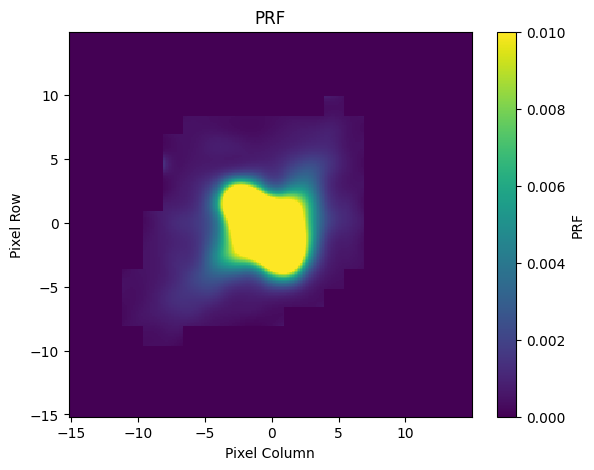

In [14]:
prf.plot();

and evaluated

In [15]:
row, column, flux = prf.evaluate()

In [56]:
flux

array([[-3.03739623e-074,  6.66698229e-072,  2.72054069e-067, ...,
        -1.29675227e-105,  8.14490753e-110,  0.00000000e+000],
       [ 2.42991699e-073, -7.91644162e-072, -6.05157045e-065, ...,
        -2.57012630e-104, -2.33474179e-107,  0.00000000e+000],
       [-1.03351689e-066, -2.90905254e-065,  4.34847067e-047, ...,
        -7.07537406e-098,  1.68148491e-089,  0.00000000e+000],
       ...,
       [-3.73884790e-084,  4.37140533e-083, -1.91776041e-077, ...,
        -6.97989831e-072, -1.57524301e-076,  0.00000000e+000],
       [-1.34990905e-088, -4.05574822e-086,  3.05953083e-068, ...,
        -1.71385091e-076,  2.02864600e-066,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

You can also get the gradient of the PRF.

In [40]:
row, column, flux, dflux = prf.evaluate(gradients=True)

The first dimension of the dflux array corresponds to the gradient taken in the x or y direction.

In [23]:
dflux.shape

(2, 32, 32)

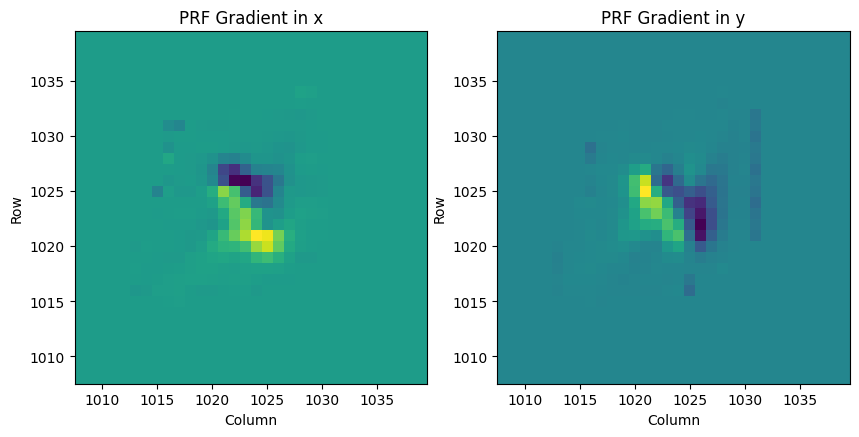

In [50]:
fig, ax = plt.subplots(1,2, figsize=[10,6])
ax[0].pcolormesh(column, row, dflux[0])
ax[1].pcolormesh(column, row, dflux[1])
ax[0].set(aspect='equal', xlabel='Column', ylabel='Row', title=f'PRF Gradient in x')
ax[1].set(aspect='equal', xlabel='Column', ylabel='Row', title=f'PRF Gradient in y');


PRFs have two key words which show where they should be evaluated on the detector

`imcorner` is the tuple of the lower left corner of the image. We see here this is set to (0, 0), for the visible detector this is the corner.

In [24]:
prf.imcorner

(0, 0)

There is also `imshape` which sets the shape of the detector.

In [9]:
prf.imshape

(2048, 2048)

`imcorner` and `imshape` set where the PRF is evaluated. So, if we want to change where the PRF is evaluated we should keep these tuples in mind.

The default for evaluation is the middle of the detector.

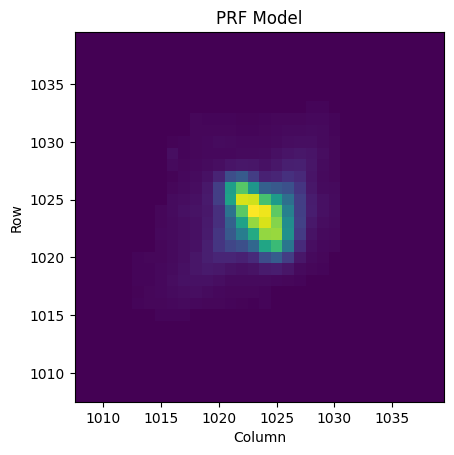

In [51]:
row, column, flux = prf.evaluate()

fig, ax = plt.subplots()
ax.pcolormesh(column, row, flux)
ax.set(aspect='equal', xlabel='Column', ylabel='Row', title='PRF Model');

But you can change where you evaluate by updating the location. The location keyword is in (row, col) format and specifies the center of where the PRF will fall.

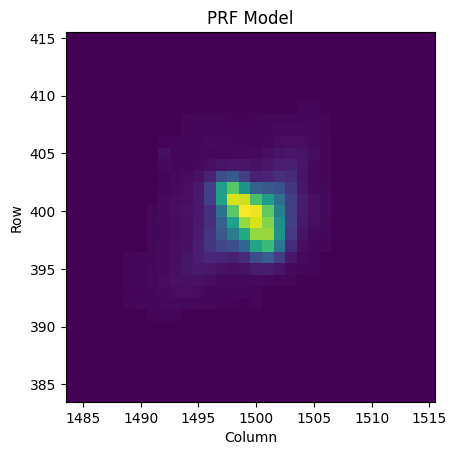

In [26]:
row, column, flux = prf.evaluate(location=(400, 1500))

fig, ax = plt.subplots()
ax.pcolormesh(column, row, flux)
ax.set(aspect='equal', xlabel='Column', ylabel='Row', title='PRF Model');

Changing the location hasn't changed the shape of the PRF, because it is a simple PRF. 

Usisng the `SpatialPRF` class will let us use PRFs whose shape is spatially dependent on where it falls on the detector.

In [27]:
prf = pa.SpatialPRF.from_reference('visda')

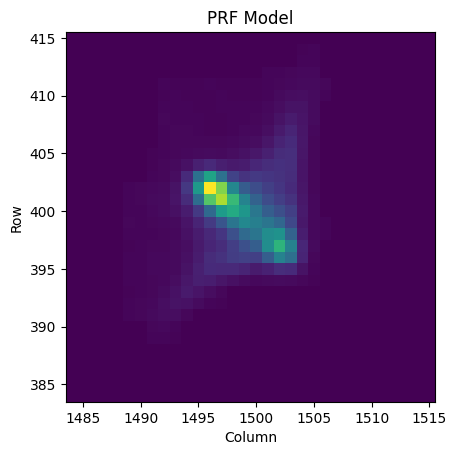

In [28]:
row, column, flux = prf.evaluate(location=(400, 1500))

fig, ax = plt.subplots()
ax.pcolormesh(column, row, flux)
ax.set(aspect='equal', xlabel='Column', ylabel='Row', title='PRF Model');

Now the PRF has changed significantly because we are far from the center. 

We can also use a `DispersedPRF` to work with the spectra on the NIRDA.

In [59]:
prf = pa.DispersedPRF.from_reference("nirda")

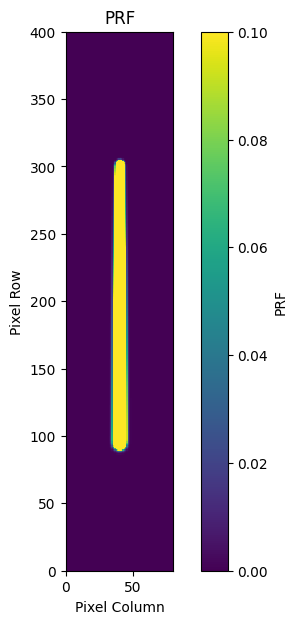

In [60]:
prf.plot();

When we evaluate this kind of PRF it is slightly different

In [61]:
row, column, flux = prf.evaluate()

In [62]:
flux.shape

(836, 42, 42)

Now the flux, row, and column are 3D. These represent the PRFs along the trace. 

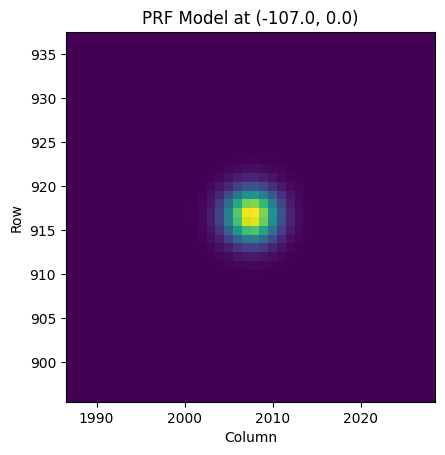

In [69]:
fig, ax = plt.subplots()
ax.pcolormesh(column[0], row[0], flux[0])
ax.set(aspect='equal', xlabel='Column', ylabel='Row', title=f'PRF Model at {(prf.trace_row[0].value, prf.trace_column[0].value)}');

Note that the `imcorner` and `imshape` for the `DispersedPRF` are different. Their new values give the default corner and shape of the science array.

In [33]:
prf.imcorner

(824, 1968)

In [34]:
prf.imshape

(400, 80)

You can update these to change the array if needed.

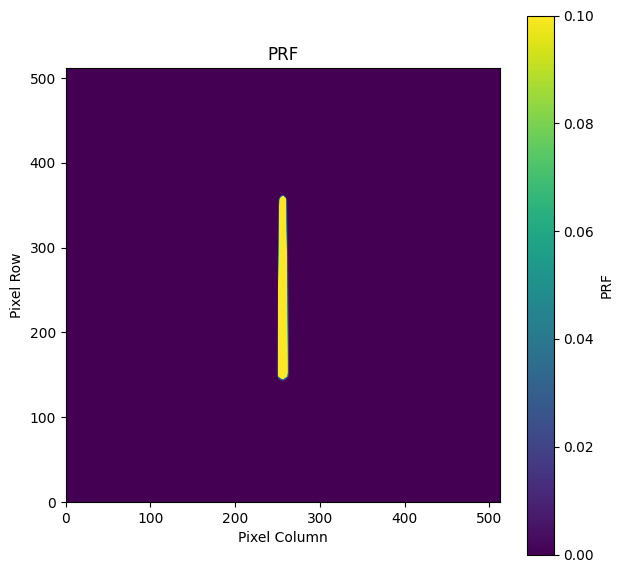

In [35]:
prf.imshape = (512, 512)
prf.plot();

You can convert all `PRF` objects to `Sparse3D` objects.

In [54]:
prf = pa.SpatialPRF.from_reference('visda')

In [26]:
X = prf.to_sparse3d(location=(1058.340985, 1012.450385))
X

<(2048, 2048, 1) Sparse3D array of type float64>

These objects embed the PRF at the correct position and have the full extent of the image. They are sparse, so they don't take up a lot of memory. 

You can perform matrix operations on `Sparse3D` objects, but you can't plot them directly. To do so, you need to first dot them with 1 to convert them to a dense array.

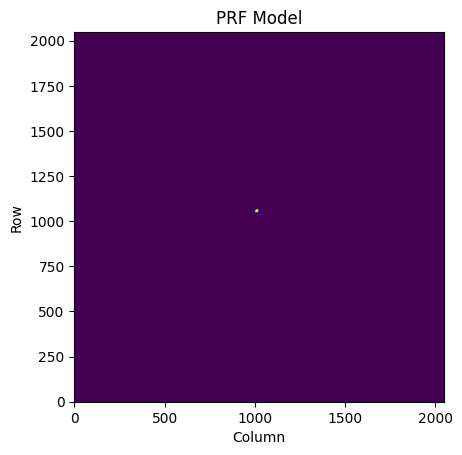

In [35]:
fig, ax = plt.subplots()
ax.imshow(X.dot(1), vmin=0, vmax=0.001, origin='lower')
ax.set(aspect='equal', xlabel='Column', ylabel='Row', title=f'PRF Model');

PRFs are designed to work with the shape of a single target. To work with a field containing many objects, use the `SkyScene` class which is demonstrated in `scene-examples.ipynb`.